# Sefer Similarity Map:

### Visualizing the landscape of Jewish texts.
_<font size="4">כי קרוב אליך הדבר</font>_ <br>

Joseph Hostyk and Alex Zaloum


Sefer Similarity Map is an exploratory tool to help uncover the substructure of books/chapters of Tanach, Talmud, and other texts in the Jewish canon, and visualize the underlying relationships between them.<br>
These relationships can illuminate historical, authorship, linguistic, and stylistic connections between texts. The tool can also pick out related texts to ones you're currently learning or teaching.<br>


### Introduction
To start measuring similarity between texts, we consider the rates of words and phrases in each individual text. Other characteristics of the texts, such as theorized date of composition or author, were not included in the model, allowing the similarities along these attributes to emerge from the comparison of the texts themselves. This [has been shown to work well](http://www.informatica.si/index.php/informatica/article/viewFile/67/59), allowing texts to be clustered together merely based on word counts.

Overall, this is a lot of data! There are around 40,000 unique words in Tanach. We have to keep track of each sefer’s rates of each of those words! That’s big enough if we just use 39 sfarim. If we switch to using subsections (e.g. the 929 prakim of Tanach), our table grows even larger.

### n-grams.
Let's make those tables even bigger!<br>
We wanted to select features that would be helpful in identifying true substructure. The counts of words is useful: a sefer that mentions Shmuel should be similar to another "Shmuel" sefer, but not to a "Rav Huna" sefer. But a “bag of words” (word counts, where order doesn’t matter) model can only contain so much information. "Rav Huna" and "Rav Yosef" each share "Rav", but should be considered differently.<br>
We therefore expanded to phrases - or “n-grams”. (A bigram is a two-word phrase; a trigram is three.) By including the counts of these n-grams, we retain more contextual information.<br>

We can add the counts of these n-grams to our matrix, so that for each text, we have both the counts of single words, but also longer phrases. We typically

### [UMAP](https://arxiv.org/pdf/1802.03426.pdf)
This process leaves us with a giant matrix, with different texts as rows, words within the corpus as columns, and each cell being the frequency of that word within that text. Texts that have similar counts of the same words will have similar rows in the table. If we view the table as a representation of a high-dimensional space, then those text would also be near each other in this space. However, visualizing this would be really difficult! We can’t draw a plot in 100-thousand dimensions.<br>
Dimensionality reduction is a technique to convert this high-dimensional data into something more manageable for us. We used a method called [UMAP](https://umap-learn.readthedocs.io/en/latest/) to reduce the dimensionality of our ngram-count matrix so that we could visualize the final result.<br>
Texts that were near each other in the original high-dimensional space (because they have similar rates of the same words) should also be close in their UMAP projections into this new 2-D space. This means that texts that group together in the UMAP space (shown in our plots below), 


### Limitations:
Using raw counts is not ideal - longer texts will have higher values overall, which can throw off the clustering. Typically, you would normalize the values based on their frequency in the corpus as a whole. [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a common method; we played around with some custom scoring metrics, but did not include them below.<br>
We do not use many of the benefits of NLP. We don’t account for prepositions. For example, "והיה" is counted differently than "היה", while ideally we should lemmatize them and count them as the same word. However, the vast amounts of data should actually wipe away many of the specific benefits NLP could bring to the table.<br>
Similarly, we did not remove extremely common words. This makes comparisons of highly-repetitive texts difficult. When we ran our method on amudim in the Talmud, we produced two large clusters, instead of many highly differentiable ones. We believe this is because most amudim share a lot of similar words, which overwhelms their unique ones.<br>
The method is severely restricted by the number of texts selected for comparison. The number of features does not affect UMAP’s runtime significantly: a corpus of 200,000 words does not run that much slower than one of 50,000 words. However, a comparison of 40 texts runs extremely quickly, while 900 texts runs over a few minutes, and the 5,350 amudim of the Talmud took very long to run.


### Results/Usage
Our code is below, with interactive results at the bottom. We ran some analyses comparing full sfarim, and some on subsections (e.g. prakim of Tanach, amudim of Talmud).<br>
By mousing over different dots, you can see the texts in the comparison. You can also search above each graph to highlight specifics texts within it.

We included some observations with each comparison. Let us know if you find any other interesting connections!<br>


### Contact

We can be reached at jhostyk [at] gmail.com and abzaloum [at] gmail.com.<br>
Please reach out with any questions, or suggestions/requests for additional plots!

### Acknowledgements

Thank you to Ben Glass for advising on the project.


In [1]:
### Dependencies:

import csv
from IPython.display import display, clear_output
import os
import itertools
from collections import defaultdict, Counter
import numpy as np

import matplotlib
# matplotlib.use('TKAgg')
import matplotlib.pyplot as plt

import spacy
import re
import unicodedata

from functools import partial
from scipy.sparse import lil_matrix, csr_matrix, csc_matrix, hstack

In [2]:
### UMAP:
import umap
import umap.plot
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
import sklearn.cluster as cluster


Loading BokehJS ...

### Load texts

In [20]:
def seferNameFromPath(seferPath):
    """
    Parse out the name.

    Args:
        seferPath (str): Full path to the sefer.

    Returns:
        The name itself.
    """
    
    return seferPath.split("/")[-3]


def getFilePaths(folder, additionalSearch = "", hebrewOrEnglish = "Hebrew"):
    """
    Recursively go through a folder and get all file names, for processing later.

    Args:
        folder (str): Full path to the folder.
        additionalSearch (str): Optional extra term in the file name. Useful for some
            Sefaria names. For gmara, "merged.txt" seemed to be the best Hebrew version.
            For Tanach, "Text Only.txt" was a non-nekudot, good version.
        hebrewOrEnglish (str): We saved a Hebrew and English version for each sefer. The
            user can specify which to load. Defaults to Hebrew.

    Returns:
        filePaths (list of strings): 
    """

#     print ("Getting file paths...")

    filePaths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if ".txt" in file and hebrewOrEnglish in root and additionalSearch in file:# and "Commentary" not in root and "Targum" not in root:
                filePaths.append(os.path.join(root, file))
    return filePaths


def getPathsForSections(sections, excludeSections):
    """
    Using the Sefaria-defined sections (e.g. "Tanakh", "Apocrypha"), get the paths
    to "merged.txt" in every subfolder.
    
    Args:
    
        sections (list of strings): Folder names; can be top-level or as low down
            (e.g. "Talmud/Bavli/Seder Moed") as desired.
        excludeSections (list of strings): Don't return files that have any of these words, in their
            path. Useful for "Commentary" or "Targum", which contain many files that may throw off
            the clustering.

    Returns:
        seferFilePaths (list of strings): Full paths to the files.
    """
    
    seferFilePaths = []
    for section in sections:
        
        seferFilePaths += getFilePaths("Texts/{}".format(section))
    
    if excludeSections:
        
        excludeIndices = []
        for index, seferFilePath in enumerate(seferFilePaths):
            
            for word in excludeSections:
                
                if word in seferFilePath:
                    
                    excludeIndices.append(index)
                    
        seferFilePaths = [seferPath for index, seferPath in enumerate(seferFilePaths) if index not in excludeIndices]         
                
    
    return seferFilePaths
        

getTanachPaths = partial(getPathsForSections, sections = ["Tanakh/Torah", "Tanakh/Prophets", "Tanakh/Writings"])

sdarim = ["Kodashim", "Moed", "Nashim", "Nezikin", "Tahorot", "Zeraim"]
sdarimPaths = ["Talmud/Bavli/Seder " + seder for seder in sdarim]
getTalmudPaths = partial(getPathsForSections, sections = sdarimPaths)

getAllPaths = partial(getPathsForSections, sections = ["."])
    

In [4]:
print ("We have {} Sefaria sfarim.".format(len(getAllPaths())))

We have 4338 Sefaria sfarim.


### Intro helper functions.

In [5]:
def makeNgramsDictionaryFromSefer(seferPath, sizeOfNgram, byPerek = False):
    """
    Read through a file and get counts of all the n-grams in it.

    Args:
        seferPath (str): Full path to the sefer file.
        sizeOfNgram (int): the length of the phrases (n-grams) to return
        byPerek (bool): If false (default), return counts of the words for the whole sefer.
            If true, return counts of words per perek.

    Returns:
        seferWords (Counter, or dict of Counters): If not byPerek, Counter of words to counts.
            If byPerek, dictionary of perek names to Counters of words to counts.
    """ 
        
    seferName = seferNameFromPath(seferPath)
    if not byPerek:
        seferNgrams = Counter()
    if byPerek:
        seferNgrams = defaultdict(Counter)
    problematicWords = set()
    
    ### For sfarim that might not be easily divided, or have an intro:
    if byPerek:
        
        perekName = seferName + " 0"
        
    with open(seferPath, "r") as psukim:
        
        ### Skip first 9 lines - metadata
        for i in range(9):
            next(psukim)
            
        for pasuk in psukim:

            ### Some quick cleaning:
            cleanedPasuk = re.sub('<[^<]+?>', '', pasuk) # ayy https://stackoverflow.com/a/4869782

            cleanedPasuk = cleanedPasuk.strip().replace("־", " ").replace("[", "").replace("]", "").replace("׃", "")
            cleanedPasuk = cleanedPasuk.replace("(פ)", "").replace("(ס)", "") ### This is for now; change later if splitting on these.
            
            ### Deal with nekudot: https://gist.github.com/yakovsh/345a71d841871cc3d375#gistcomment-1672181
            normalized = unicodedata.normalize('NFKD', cleanedPasuk)
            cleanedPasuk = "".join([c for c in normalized if not unicodedata.combining(c)])
            
            splitPasuk = cleanedPasuk.split(" ")

            # Skip the non-text lines.
            if len(splitPasuk) == 1:
                continue
            
            if splitPasuk[0] == "הקדמה":
                
                perekName = seferName + " 0" # Or is "_ Introduction" better?
            if splitPasuk[0] in ["Chapter", "chapter", "Section", "Seif", "Part", "Daf", "Nahar", "Parasha", "פרשת", "Klal"]:
                 ## "Siman"? Paragraph"? "Gate"? "פרשת" seems risky, in case a sentence begins with it.
                
                if byPerek:
                    
                    perekNumber = splitPasuk[1]
                    perekName = seferName + " " + perekNumber
                    
                continue

                
            ### Delete spaces:
            if [""] in splitPasuk:
                splitPasuk.remove([""])
            for wordIndex in range(len(splitPasuk) - sizeOfNgram + 1):
                
#                 if word == "":
#                     continue
                try:
                    
                    ngram = " ".join(splitPasuk[wordIndex:wordIndex + sizeOfNgram])
                    if not byPerek:
                        seferNgrams[ngram] += 1

                    if byPerek:
                        
                        seferNgrams[perekName][ngram] += 1

                except KeyError as e:
                    problematicWords.add(ngram)
                    
                              
    return seferNgrams

makeWordDictionaryFromSefer = partial(makeNgramsDictionaryFromSefer, sizeOfNgram = 1)


In [6]:
def getNgramCountsBySefer(seferPaths, sizeOfNgram, byPerek = False, removeExclusiveNgrams = True):
    """
    Get counts of all words in a list of sfarim.

    Args:
        seferPaths (list of strings): Full paths to the sfarim to analyze.
        byPerek (bool): If false (default), return counts of the words by sefer.
            If true, return counts of words per perek/subsection.
        removeExclusiveNgrams (bool): Remove any ngram that only shows up in one
            of the selected sections.

    Returns:
        sfarimToWords (dict of Counters): Keep track of the rates of each word/phrase
            in each sefer/perek. e.g. {sefer1: {word1: counts, word2: ...}}
        sfarimToSizeOfSefer (dict): Keep track of the size of each text, for normalization later.
    """   
    
    sfarimToWords = {} ### Dict of dicts
    sfarimToSizeOfSefer = dict() ### dict of {seferName: int}
    
    
    ### Keep track of total counts, to remove later:
    for seferPath in seferPaths:
        

        seferName = seferNameFromPath(seferPath)
        wordsInSefer = makeNgramsDictionaryFromSefer(seferPath = seferPath, sizeOfNgram = sizeOfNgram, byPerek = byPerek)

        if not byPerek:
            sfarimToWords[seferName] = wordsInSefer
            sfarimToSizeOfSefer[seferName] = sum(wordsInSefer.values())
            

        ### If running by perek, have a dict of Counters. Need to extract.
        if byPerek:
#           sfarimToWords.update(wordsInSefer)
            for perekName, perekCounts in wordsInSefer.items():

                sfarimToWords[perekName] = perekCounts
                sfarimToSizeOfSefer[perekName] = sum(perekCounts.values())
    
    if not removeExclusiveNgrams or sizeOfNgram == 1:
        
        if sizeOfNgram == 1:
            
            print ("Keeping all n-grams of size 1.")
        
        return sfarimToWords, sfarimToSizeOfSefer
    
    ### Otherwise, by default, reemove ngrams that only show up in one of the sections.

    wordsToNumberOfSfarimTheyAppearIn = Counter()

    ## Find how many sfarim each word appears in.
    for seferName, seferToWords in sfarimToWords.items():

        for word in seferToWords:

            wordsToNumberOfSfarimTheyAppearIn[word] += 1


    ### Remove the most infrequent:
    wordsToRemove = set()
    for word, numberOfSfarimThatWordAppearsIn in wordsToNumberOfSfarimTheyAppearIn.items():

        if numberOfSfarimThatWordAppearsIn == 1: # < len(seferPaths) / 10.0: ### magic parameter to play around with:


            wordsToRemove.add(word)

    print ("Removing {} ngrams that only appear in one section.".format(len(wordsToRemove)))

    ### Deleting from original dict took too long, so we create a new one, and delete the entire old one.
    cleanedSfarimToWords = {}

    for seferName, seferToWords in sfarimToWords.items():

        cleanedSfarimToWords[seferName] = Counter({word: counts for word, counts in seferToWords.items() if word not in wordsToRemove})

    sfarimToWords.clear()

                
    return cleanedSfarimToWords, sfarimToSizeOfSefer

getWordCountsBySefer = partial(getNgramCountsBySefer, sizeOfNgram = 1)

getTanachWordCountsBySefer = partial(getWordCountsBySefer, seferPaths = getTanachPaths())
getTalmudWordCountsBySefer = partial(getWordCountsBySefer, seferPaths = getTalmudPaths())
getAllWordCountsBySefer = partial(getWordCountsBySefer, seferPaths = getAllPaths())

getTanachNgramCountsBySefer = partial(getNgramCountsBySefer, seferPaths = getTanachPaths())
getTalmudNgramCountsBySefer = partial(getNgramCountsBySefer, seferPaths = getTalmudPaths())
getAllNgramCountsBySefer = partial(getNgramCountsBySefer, seferPaths = getAllPaths())


# UMAP

In [19]:
def makeNgramMatrix(sfarimToWords, sfarimToSizeOfSefer):
    """
    Prep the UMAP input.

    Args:
        sfarimToWords (dict of Counters): Keep track of the rates of each word/phrase
            in each sefer/perek. e.g. {sefer1: {word1: counts, word2: ...}}
        sfarimToSizeOfSefer (dict): Keep track of the size of each text, for normalization later.

    Returns:
        wordsMatrix (numpy sparse column matrix): Rows are the names of the sections, columns are the
            words/ngrams.

    """    
    ### Get all words:
    allWordsInSelection = set()
    sfarim = sorted(sfarimToWords)
    for sefer, wordsCounter in sfarimToWords.items():

        seferWords = set(wordsCounter)

        allWordsInSelection |= seferWords

    allWordsInSelection = sorted(allWordsInSelection) # Turn into list and sort.
    numberWordsInSelection = len(allWordsInSelection)
    numberSfarim = len(sfarimToWords)

    print ("In the {} selected sections, there are {} unique ngrams.".format(numberSfarim, numberWordsInSelection))

    ### Use sparse matrix:
    wordsMatrix = lil_matrix((numberSfarim, numberWordsInSelection))
    
    ### Fill in matrix:
    for seferNumber, (sefer, seferWordCounts) in enumerate(sorted(sfarimToWords.items())):

        ### raw frequency:
        counts = [seferWordCounts[word] for word in allWordsInSelection]

        ### special scoring:
        #     counts = [seferWordCounts[word] * np.lo for word in allWordsInSelection]

        wordsMatrix[seferNumber] = counts        

    wordsMatrix = csc_matrix(wordsMatrix)
    return wordsMatrix

def getUMAPembedding(wordsMatrix):
    """
    Actually running UMAP.
    Args:
        sfarimToWords ():

    Returns:
        The gmatria (int)

    """       
    embedding = umap.UMAP(n_components=2, metric='hellinger').fit(wordsMatrix)
    return embedding
#     print (embedding.embedding_.shape)

    ### Instead of perek names, just do Sefer names.
    ### This breaks if not doing byPerek.

def plotUMAP(embedding, sfarim, byPerek = False, interactive = True):
    """
    Plotting for UMAP.
    Args:
        sfarimToWords ():

    Returns:
        The gmatria (int)

    """   

    ### Pull out the sefer name - e.g. "Amos" from "Amos 1"
    if byPerek and not interactive:
        sfarim = [" ".join(sefer.split(" ")[:-1]) for sefer in sfarim]
        
        
    labels = pd.DataFrame(sfarim, columns=["Sefer"])
    
    if interactive:
        f = umap.plot.interactive(embedding, labels=labels["Sefer"], hover_data=labels, point_size=10, interactive_text_search = True, interactive_text_search_alpha_contrast = 0.8)
        show(f)
    else:
#         f = umap.plot.points(embedding, labels=labels["Sefer"])
        
#         umap.plot.points(embedding, labels=labels["Sefer"], theme='fire')
        umap.plot.connectivity(embedding, edge_bundling='hammer', show_points=True)
        

def runUMAP(numNgramsToRun, selectedSections = None, excludeSections = None, byPerek = False, interactive = True, removeExclusiveNgrams = False):
    """
    Handler function for UMAP.
    Args:
        sfarimToWords ():

    Returns:
        The gmatria (int)

    """

    createdMatrix = False
    for sizeOfNgram in range(1, numNgramsToRun + 1):

        print ("ngram size:", sizeOfNgram)
        
        ### If user chooses something:
        if selectedSections:
            seferPaths = getPathsForSections(selectedSections, excludeSections = excludeSections)
            print ("Running on {} items...".format(len(seferPaths)))
            sfarimToWords, sfarimToSizeOfSefer = getNgramCountsBySefer(seferPaths = seferPaths, sizeOfNgram = sizeOfNgram, byPerek = byPerek, removeExclusiveNgrams = removeExclusiveNgrams)
         
        ### For testing:
        ### If sections aren't put in, use getTanachNgramCountsBySefer or getTalmudNgramCountsBySefer
        else:
            sfarimToWords, sfarimToSizeOfSefer = getTalmudNgramCountsBySefer(sizeOfNgram = sizeOfNgram, byPerek = byPerek, removeExclusiveNgrams = removeExclusiveNgrams)
        
        ngramMatrix = makeNgramMatrix(sfarimToWords, sfarimToSizeOfSefer)

        if not createdMatrix:
            fullMatrix = ngramMatrix
            createdMatrix = True

        if createdMatrix:
            fullMatrix = hstack([fullMatrix, ngramMatrix])
    
    print ("Made matrix; now embedding")       
    sfarim = sorted(sfarimToSizeOfSefer.keys())
    embedding = getUMAPembedding(fullMatrix)
    plotUMAP(embedding, sfarim, byPerek, interactive)
    
    return embedding, sfarim
    
    

# Results

## 929 Prakim of Tanach

In [8]:
embedding, sfarim = runUMAP(numNgramsToRun = 3, byPerek = True, interactive = True, removeExclusiveNgrams = True)


ngram size: 1
Keeping all n-grams of size 1.
In the 929 selected sections, there are 39995 unique words.
ngram size: 2
Removing 156551 ngrams that only appear in one section.
In the 929 selected sections, there are 28101 unique words.
ngram size: 3
Removing 215330 ngrams that only appear in one section.
In the 929 selected sections, there are 15003 unique words.
made matrix; now embedding


### Interpretation:

 - Prakim within individual sfarim are usually close to each other.
 - However, some are found in separate clusters. For example, certain chapters of Ezra/Daniel cluster on their own. These are the only Aramaic chapters in Tanach, so they don't share any words with other chapters, and cluster separately!<br>
 - Ezra and Nechemia are near each other, because of their duplicated passages.<br>
 - The 5 books of the Torah are all mostly near each other, with each comprising a mostly distinct cluster.

## Shulchan Aruch and Commentary

In [9]:
embedding, sfarim = runUMAP(numNgramsToRun = 1, byPerek = False, selectedSections = ["Halakhah/Shulchan Arukh"], interactive = True, removeExclusiveNgrams = True)

ngram size: 1
Running on 66 items...
Keeping all n-grams of size 1.
In the 66 selected sections, there are 383227 unique words.
made matrix; now embedding


### Interpretation:

(We couldn't get the apostrophes to show up correctly for some of these labels - sorry!)

- Each of the four sections of the Shulchan Aruch is in a separate, primary cluster. <br>
- Each of those sections is surrounded by its commentaries. <br>
- Lots of speculation based on Wikipedia searching - let us know if you think of other interesting connections!
- The Kaf HaChaim is near the Mishnah Berurah. According to [Wikipedia](https://en.wikipedia.org/wiki/Yaakov_Chaim_Sofer): "Kaf HaChaim is often compared to the Mishna Berura in terms of scope and approach, but differs in its more extensive reliance upon quotations." <br>
- The Dagul Mervava is next to the [Yad Efraim](https://en.wikipedia.org/wiki/Ephraim_Zalman_Margolioth). The two were known to be in correspondence!<br>
- Not far off from these two are the Eshel Avraham and Shaarei Teshuvah, who lived in the same time and place (Poland/Galaica, end of 18th/beginning of 19th century). <br>
- The Magen Avraham on Orach Chaim is near three of its subcommentators: Machazitz haShekel, Levushei Serad, and Rabbi Akiva Eiger. The latter is also near Turei Zahav (the Taz), upon which Rabbi Akiva Eger wrote commentary. <br>
- The Be’ur HaGra and Be’er HaGolah are both terse commentaries whose main purpose is to provide cross-references, hence their separation from the rest of the supercommentaries and their proximity to one another. <br>



### Edge Visualization

Below, we show the connections between different clusters. They aren't too informative, but show the relative strength/distances between groupings.

/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/umap/plot.py:850: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"
/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/datashader/transfer_functions/__init__.py:303: RuntimeWarning: invalid value encountered in true_divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<IPython.core.display.Javascript object>


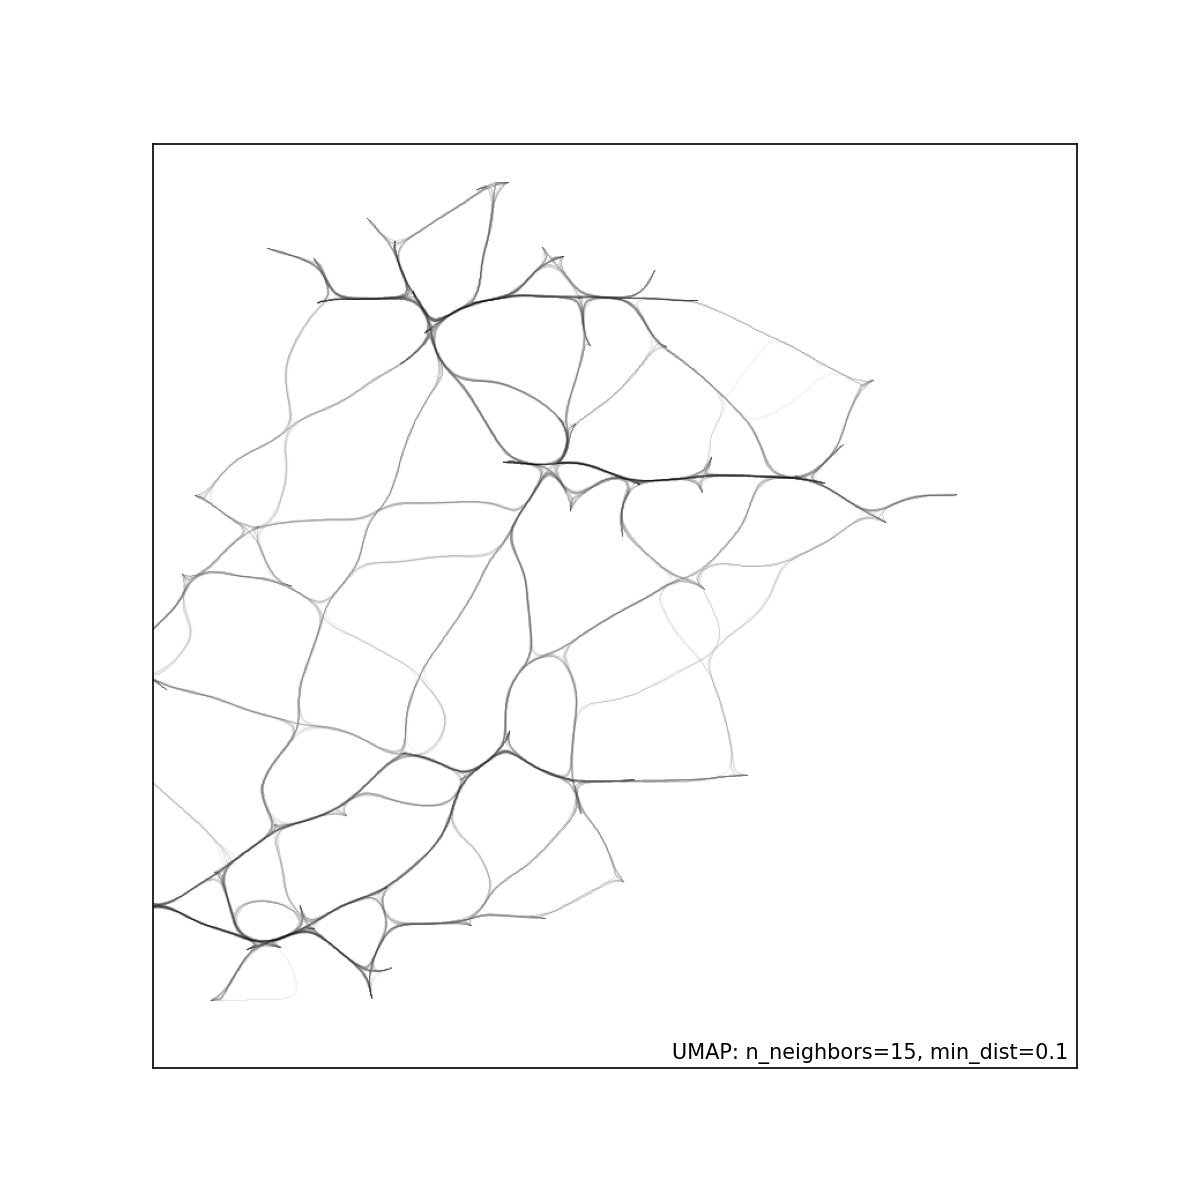

In [16]:
plotUMAP(embedding, sfarim, byPerek = False, interactive = False)

## Sfarim of Tanach + Apocrypha

In [21]:
embedding, sfarim = runUMAP(numNgramsToRun = 1, byPerek = False, selectedSections = ["Apocrypha", "Tanakh"], excludeSections = ["Commentary", "Targum"], interactive = True, removeExclusiveNgrams = True)


ngram size: 1
Running on 53 items...
Keeping all n-grams of size 1.
In the 53 selected sections, there are 55534 unique ngrams.
made matrix; now embedding


### Interpretation

- Here, we ran on the full sfarim, without breaking them down into prakim. Many of the apocryphal texts are separate, at the top.
- Interestingly, Wisdom of Solomon is near Ecclesiastes. However, as pointed out by our colleague Ben Glass, this is actually odd because the Hebrew text we have for Wisdom of Solomon is a translation, as it was originally written in Greek.

## Amudim of the Talmud

In [22]:
embedding, sfarim = runUMAP(numNgramsToRun = 1, byPerek = True, interactive = True, removeExclusiveNgrams = True)


ngram size: 1
Keeping all n-grams of size 1.
In the 5350 selected sections, there are 112522 unique ngrams.
made matrix; now embedding


### Interpretation:

This plot shows some of the failing of our methods, when run using single-word phrases. Brachot and Shabbos are separate clusters, but the majority of amudim in the Talmud are clustered next to each other. We wish we could run on larger phrases, but our computers couldn't handle it.

However, we believe this can be extremely useful as a pedagogical aid! If you've begun learning a certain page of gemara, you can search for it here, and then pan over nearby amudim to find ones that have similar vocabulary/word usage.

In [23]:
embedding, sfarim = runUMAP(numNgramsToRun = 1, selectedSections = ["Kabbalah"], byPerek = True, interactive = True, removeExclusiveNgrams = True)


ngram size: 1
Running on 37 items...
Keeping all n-grams of size 1.
In the 1876 selected sections, there are 250070 unique ngrams.
made matrix; now embedding


### Interpretation

Until now, we've tried to show texts that have some relevance, so that the comparisons are more meaningful. This graph of Kabbalah texts shows the strength of the method when comparing wildly varied texts. The Zohar/Tikkunei Zohar texts are completely on their own to the side! As are a few of the other texts, with the remainder clustering together.